# Import Required Libraries

In [1]:
WANDB = False
EXP_NAME = "val5_effnetb0_norm_by_patient"
# EXP_NAME = "try"

if WANDB:
    # !pip install wandb
    import wandb
    import os
    from dotenv import load_dotenv
    load_dotenv()
    wandb.login(key=os.environ.get("WANDB_API_KEY"))

In [2]:
# !apt-get install -y libgl1-mesa-dev


In [3]:
import os
import gc
import cv2
import math
import copy
import time
import random
import glob
from matplotlib import pyplot as plt
import seaborn as sns
from PIL import Image

# For data manipulation
import numpy as np
import pandas as pd

# Pytorch Imports
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.optim import lr_scheduler
from torch.utils.data import Dataset, DataLoader
from torch.cuda import amp
import torchvision
# from torcheval.metrics.functional import binary_auroc

# Utils
import joblib
from tqdm import tqdm
from collections import defaultdict

# Sklearn Imports
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedKFold, StratifiedGroupKFold 
from sklearn.metrics import roc_auc_score

# For Image Models
import timm

# Albumentations for augmentations
import albumentations as A
from albumentations.pytorch import ToTensorV2

# For colored terminal text
from colorama import Fore, Back, Style
b_ = Fore.BLUE
sr_ = Style.RESET_ALL

import warnings
warnings.filterwarnings("ignore")

# For descriptive error messages
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"

# Training Configuration

In [4]:
CONFIG = {
    "seed": 42,
    "epochs": 30,
    # "epochs": 3, #######　後でなおすこと
    "img_size": 256,
    "model_name": "tf_efficientnet_b0_ns",
    "checkpoint_path" : "/kaggle/input/tf-efficientnet/pytorch/tf-efficientnet-b0/1/tf_efficientnet_b0_aa-827b6e33.pth",
    "train_batch_size": 64,
    "valid_batch_size": 128,
    "learning_rate": 1e-3,
    "scheduler": 'CosineAnnealingLR',
    "min_lr": 1e-8,
#     "T_max": 10316,
    "weight_decay": 1e-5,
    "fold" : 0,
    "n_fold": 5,
    "n_accumulate": 1,
    "device": torch.device("cuda:0" if torch.cuda.is_available() else "cpu"),
    "save_dir": "../proc/val3",
    "use_tta": False,
    "mixup_alpha": 0.35,  # 既存のMixupのパラメータ
    "mixup_epochs": 20,  # Mixupを適用するエポック数を追加
}

# Set Seed for Reproducibility

In [5]:
def set_seed(seed=42):
    '''Sets the seed of the entire notebook so results are the same every time we run.
    This is for REPRODUCIBILITY.'''
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    # When running on the CuDNN backend, two further options must be set
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    # Set a fixed value for the hash seed
    os.environ['PYTHONHASHSEED'] = str(seed)
    
set_seed(CONFIG['seed'])

In [6]:
ROOT_DIR = "../raw"
TRAIN_DIR = f'{ROOT_DIR}/train-image/image'

In [7]:
def get_train_file_path(image_id):
    return f"{TRAIN_DIR}/{image_id}.jpg"

# Read the Data

In [8]:
train_images = sorted(glob.glob(f"{TRAIN_DIR}/*.jpg"))

In [9]:
df = pd.read_csv(f"{ROOT_DIR}/train-metadata.csv")
print(df.shape)
df['file_path'] = df['isic_id'].apply(get_train_file_path)
df = df[ df["file_path"].isin(train_images) ].reset_index(drop=True)
df

(401059, 55)


,isic_id,target,patient_id,age_approx,sex,anatom_site_general,clin_size_long_diam_mm,image_type,tbp_tile_type,tbp_lv_A,...,iddx_full,iddx_1,iddx_2,iddx_3,iddx_4,iddx_5,mel_mitotic_index,mel_thick_mm,tbp_lv_dnn_lesion_confidence,file_path
0,ISIC_0015670,0,IP_1235828,60.0,male,lower extremity,3.04,TBP tile: close-up,3D: white,20.244422,...,Benign,Benign,NaN,NaN,NaN,NaN,NaN,NaN,97.517282,../raw/train-image/image/ISIC_0015670.jpg
1,ISIC_0015845,0,IP_8170065,60.0,male,head/neck,1.10,TBP tile: close-up,3D: white,31.712570,...,Benign,Benign,NaN,NaN,NaN,NaN,NaN,NaN,3.141455,../raw/train-image/image/ISIC_0015845.jpg
2,ISIC_0015864,0,IP_6724798,60.0,male,posterior torso,3.40,TBP tile: close-up,3D: XP,22.575830,...,Benign,Benign,NaN,NaN,NaN,NaN,NaN,NaN,99.804040,../raw/train-image/image/ISIC_0015864.jpg
3,ISIC_0015902,0,IP_4111386,65.0,male,anterior torso,3.22,TBP tile: close-up,3D: XP,14.242329,...,Benign,Benign,NaN,NaN,NaN,NaN,NaN,NaN,99.989998,../raw/train-image/image/ISIC_0015902.jpg
4,ISIC_0024200,0,IP_8313778,55.0,male,anterior torso,2.73,TBP tile: close-up,3D: white,24.725520,...,Benign,Benign,NaN,NaN,NaN,NaN,NaN,NaN,70.442510,../raw/train-image/image/ISIC_0024200.jpg
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
401054,ISIC_9999937,0,IP_1140263,70.0,male,anterior torso,6.80,TBP tile: close-up,3D: XP,22.574335,...,Benign,Benign,NaN,NaN,NaN,NaN,NaN,NaN,99.999988,../raw/train-image/image/ISIC_9999937.jpg
401055,ISIC_9999951,0,IP_5678181,60.0,male,posterior torso,3.11,TBP tile: close-up,3D: white,19.977640,...,Benign,Benign,NaN,NaN,NaN,NaN,NaN,NaN,99.999820,../raw/train-image/image/ISIC_9999951.jpg
401056,ISIC_9999960,0,IP_0076153,65.0,female,anterior torso,2.05,TBP tile: close-up,3D: XP,17.332567,...,Benign,Benign,NaN,NaN,NaN,NaN,NaN,NaN,99.999416,../raw/train-image/image/ISIC_9999960.jpg
401057,ISIC_9999964,0,IP_5231513,30.0,female,anterior torso,2.80,TBP tile: close-up,3D: XP,22.288570,...,Benign,Benign,NaN,NaN,NaN,NaN,NaN,NaN,100.000000,../raw/train-image/image/ISIC_9999964.jpg


In [10]:
df.shape[0], df.target.sum()

(401059, 393)

# <span><h1 style = "font-family: garamond; font-size: 40px; font-style: normal; letter-spcaing: 3px; background-color: #f6f5f5; color :#fe346e; border-radius: 100px 100px; text-align:center">Create Folds</h1></span>

In [11]:
sgkf = StratifiedGroupKFold(n_splits=CONFIG['n_fold'], shuffle=True, random_state=0)

for fold, ( _, val_) in enumerate(sgkf.split(df, df.target, df.patient_id)):
      df.loc[val_ , "kfold"] = int(fold)
        
# df[["isic_id", "kfold"]].to_csv("df_fold.csv", index=False)
df[["isic_id", "kfold"]]

,isic_id,kfold
0,ISIC_0015670,4.0
1,ISIC_0015845,2.0
2,ISIC_0015864,1.0
3,ISIC_0015902,2.0
4,ISIC_0024200,1.0
...,...,...
401054,ISIC_9999937,1.0
401055,ISIC_9999951,3.0
401056,ISIC_9999960,0.0
401057,ISIC_9999964,2.0


# <span><h1 style = "font-family: garamond; font-size: 40px; font-style: normal; letter-spcaing: 3px; background-color: #f6f5f5; color :#fe346e; border-radius: 100px 100px; text-align:center">Dataset Class</h1></span>

In [12]:
# 1. 各patientごとの平均値と標準偏差を計算
def calculate_patient_stats(df):
    patient_stats = defaultdict(lambda: {'mean': np.zeros(3), 'std': np.zeros(3), 'count': 0})
    
    patient_ids = df["patient_id"].values
    isic_ids = df["isic_id"].values
    for patient_id, isic_id in zip(patient_ids, isic_ids):
        img_path = get_train_file_path(isic_id)
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        
        img = img / 255.0
        patient_stats[patient_id]['mean'] += np.mean(img, axis=(0, 1))
        # patient_stats[patient_id]['sum_sq'] += np.sum(np.square(img), axis=(0, 1))
        patient_stats[patient_id]['std'] += np.std(img, axis=(0, 1))
        patient_stats[patient_id]['count'] += 1
    
    for patient_id, stats in patient_stats.items():
        mean = stats['mean'] / stats['count']
        std = stats['std'] / stats['count']
        patient_stats[patient_id] = {'mean': mean, 'std': std}
    
    return patient_stats

# 2. 計算した統計値を保存
patient_stats = calculate_patient_stats(df)

In [13]:
def get_data_transforms(patient_id, dict_norm=patient_stats):
    data_transforms = {
        "train": A.Compose([
            A.Resize(CONFIG['img_size'], CONFIG['img_size']),
            A.RandomRotate90(p=0.5),
            A.Flip(p=0.5),
            A.Downscale(p=0.25),
            A.ShiftScaleRotate(shift_limit=0.1, 
                            scale_limit=0.15, 
                            rotate_limit=60, 
                            p=0.5),
            A.HueSaturationValue(
                    hue_shift_limit=0.2, 
                    sat_shift_limit=0.2, 
                    val_shift_limit=0.2, 
                    p=0.5
                ),
            A.RandomBrightnessContrast(
                    brightness_limit=(-0.1,0.1), 
                    contrast_limit=(-0.1, 0.1), 
                    p=0.5
                ),
            A.Normalize(
                    mean=dict_norm[patient_id]['mean'], 
                    std=dict_norm[patient_id]['std'], 
                    max_pixel_value=255.0, 
                    p=1.0
                ),
            ToTensorV2()], p=1.),

        "valid": A.Compose([
            A.Resize(CONFIG['img_size'], CONFIG['img_size']),
            A.Normalize(
                    mean=dict_norm[patient_id]['mean'], 
                    std=dict_norm[patient_id]['std'], 
                    max_pixel_value=255.0, 
                    p=1.0
                ),
            ToTensorV2()], p=1.),
    }
    return data_transforms

In [14]:
class ISICDataset_for_Train(Dataset):
    def __init__(self, df):
        self.df_positive = df[df["target"] == 1].reset_index()
        self.df_negative = df[df["target"] == 0].reset_index()
        self.file_names_positive = self.df_positive['file_path'].values
        self.file_names_negative = self.df_negative['file_path'].values
        self.targets_positive = self.df_positive['target'].values
        self.targets_negative = self.df_negative['target'].values
        self.patient_ids_positive = self.df_positive['patient_id'].values
        self.patient_ids_negative = self.df_negative['patient_id'].values
        
    def __len__(self):
        return len(self.df_positive) * 2
    
    def __getitem__(self, index):
        if random.random() >= 0.5:
            df = self.df_positive
            file_names = self.file_names_positive
            targets = self.targets_positive
            patient_ids = self.patient_ids_positive
        else:
            df = self.df_negative
            file_names = self.file_names_negative
            targets = self.targets_negative
            patient_ids = self.patient_ids_negative
        index = index % df.shape[0]
        
        img_path = file_names[index]
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        target = targets[index]
        patient_id = patient_ids[index]
        
        img = get_data_transforms(patient_id)["train"](image=img)["image"]
            
        return {
            'image': img,
            'target': target
        }

class ISICDataset(Dataset):
    def __init__(self, df):
        self.df = df
        self.file_names = df['file_path'].values
        self.targets = df['target'].values
        self.patient_ids = df["patient_id"].values
        
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, index):
        img_path = self.file_names[index]
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        target = self.targets[index]
        patient_id = self.patient_ids[index]
        
        img = get_data_transforms(patient_id)["valid"](image=img)["image"]
            
        return {
            'image': img,
            'target': target
        }

# <span><h1 style = "font-family: garamond; font-size: 40px; font-style: normal; letter-spcaing: 3px; background-color: #f6f5f5; color :#fe346e; border-radius: 100px 100px; text-align:center">Augmentations</h1></span>

In [15]:
# Mixupを行う関数を追加
def mixup(x: torch.Tensor, y: torch.Tensor, alpha: float = 0.4):
    assert alpha > 0, "alpha should be larger than 0"
    assert x.size(0) > 1, "Batch size should be larger than 1"

    lam = np.random.beta(alpha, alpha)
    rand_index = torch.randperm(x.size()[0])
    mixed_x = lam * x + (1 - lam) * x[rand_index, :]
    target_a, target_b = y, y[rand_index]
    return mixed_x, target_a, target_b, lam

# <span><h1 style = "font-family: garamond; font-size: 40px; font-style: normal; letter-spcaing: 3px; background-color: #f6f5f5; color :#fe346e; border-radius: 100px 100px; text-align:center">GeM Pooling</h1></span>

In [16]:
class GeM(nn.Module):
    def __init__(self, p=3, eps=1e-6):
        super(GeM, self).__init__()
        self.p = nn.Parameter(torch.ones(1)*p)
        self.eps = eps

    def forward(self, x):
        return self.gem(x, p=self.p, eps=self.eps)
        
    def gem(self, x, p=3, eps=1e-6):
        return F.avg_pool2d(x.clamp(min=eps).pow(p), (x.size(-2), x.size(-1))).pow(1./p)
        
    def __repr__(self):
        return self.__class__.__name__ + \
                '(' + 'p=' + '{:.4f}'.format(self.p.data.tolist()[0]) + \
                ', ' + 'eps=' + str(self.eps) + ')'

# <span><h1 style = "font-family: garamond; font-size: 40px; font-style: normal; letter-spcaing: 3px; background-color: #f6f5f5; color :#fe346e; border-radius: 100px 100px; text-align:center">Create Model</h1></span>

In [17]:
class ISICModel(nn.Module):
    def __init__(self, model_name, num_classes=1, pretrained=True, checkpoint_path=None):
        super(ISICModel, self).__init__()
        self.model = timm.create_model(model_name, pretrained=pretrained, checkpoint_path=checkpoint_path)

        in_features = self.model.classifier.in_features
        self.model.classifier = nn.Identity()
        self.model.global_pool = nn.Identity()
        self.pooling = GeM()
        self.linear = nn.Linear(in_features, num_classes)
        self.sigmoid = nn.Sigmoid()

    def forward(self, images):
        features = self.model(images)
        pooled_features = self.pooling(features).flatten(1)
        output = self.sigmoid(self.linear(pooled_features))
        return output

# <span><h1 style = "font-family: garamond; font-size: 40px; font-style: normal; letter-spcaing: 3px; background-color: #f6f5f5; color :#fe346e; border-radius: 100px 100px; text-align:center">Loss Function</h1></span>

In [18]:
def criterion(outputs, targets):
    return nn.BCELoss()(outputs, targets)
#     return nn.CrossEntropyLoss()(outputs, targets) 

# <span><h1 style = "font-family: garamond; font-size: 40px; font-style: normal; letter-spcaing: 3px; background-color: #f6f5f5; color :#fe346e; border-radius: 100px 100px; text-align:center">Training Function</h1></span>

In [19]:
def comp_score_list(solution: list, submission: list, min_tpr: float=0.80):
    v_gt = np.abs(np.array(solution)-1)
    v_pred = np.array([1.0 - x for x in submission])
    max_fpr = abs(1-min_tpr)
    partial_auc_scaled = roc_auc_score(v_gt, v_pred, max_fpr=max_fpr)
    # change scale from [0.5, 1.0] to [0.5 * max_fpr**2, max_fpr]
    # https://math.stackexchange.com/questions/914823/shift-numbers-into-a-different-range
    partial_auc = 0.5 * max_fpr**2 + (max_fpr - 0.5 * max_fpr**2) / (1.0 - 0.5) * (partial_auc_scaled - 0.5)
    return partial_auc

In [20]:
def train_one_epoch(model, optimizer, scheduler, dataloader, device, epoch):
    model.train()
    
    dataset_size = 0
    running_loss = 0.0
    
    bar = tqdm(enumerate(dataloader), total=len(dataloader))
    for step, data in bar:
        images = data['image'].to(device, dtype=torch.float)
        targets = data['target'].to(device, dtype=torch.float)
        
        batch_size = images.size(0)
        
        # Mixupを設定されたエポック数まで適用
        if epoch <= CONFIG['mixup_epochs']:
            mixed_images, targets_a, targets_b, lam = mixup(images, targets, alpha=CONFIG['mixup_alpha'])
            outputs = model(mixed_images).squeeze()
            loss = lam * criterion(outputs, targets_a) + (1 - lam) * criterion(outputs, targets_b)
        else:
            outputs = model(images).squeeze()
            loss = criterion(outputs, targets)
            
        loss = loss / CONFIG['n_accumulate']
            
        loss.backward()
    
        if (step + 1) % CONFIG['n_accumulate'] == 0:
            optimizer.step()

            # zero the parameter gradients
            optimizer.zero_grad()

            if scheduler is not None:
                scheduler.step()
        
        running_loss += (loss.item() * batch_size)
        dataset_size += batch_size
        
        epoch_loss = running_loss / dataset_size
        
        bar.set_postfix(Epoch=epoch, Train_Loss=epoch_loss,
                        LR=optimizer.param_groups[0]['lr'])
    
    gc.collect()
    
    return epoch_loss

# <span><h1 style = "font-family: garamond; font-size: 40px; font-style: normal; letter-spcaing: 3px; background-color: #f6f5f5; color :#fe346e; border-radius: 100px 100px; text-align:center">Validation Function</h1></span>

In [21]:
@torch.inference_mode()
def valid_one_epoch(model, dataloader, device, epoch):
    model.eval()
    
    dataset_size = 0
    running_loss = 0.0
    running_auroc = 0.0
    
    # TTAのためのカウンター
    tta_counter = 0
    
    # TTAのための関数を定義
    def apply_tta(model, image):
        outputs = []
        
        # オリジナル画像
        outputs.append(model(image).squeeze())
        
        # 水平フリップ
        outputs.append(model(torch.flip(image, dims=[3])).squeeze())
        
        # 垂直フリップ
        outputs.append(model(torch.flip(image, dims=[2])).squeeze())
        
        # 90度、180度、270度回転
        for k in [1, 2, 3]:
            outputs.append(model(torch.rot90(image, k, dims=[2,3])).squeeze())
        
        return torch.stack(outputs).mean(dim=0)
    
    all_outputs = []
    all_targets = []
    
    bar = tqdm(enumerate(dataloader), total=len(dataloader))
    for step, data in bar:        
        images = data['image'].to(device, dtype=torch.float)
        targets = data['target'].to(device, dtype=torch.float)
        
        batch_size = images.size(0)

        if CONFIG['use_tta']:
            outputs = apply_tta(model, images).squeeze()
        else:
            outputs = model(images).squeeze()
        loss = criterion(outputs, targets)
        
        all_outputs.extend(outputs.detach().cpu().numpy().flatten())  # 確率に変換して蓄積
        all_targets.extend(targets.detach().cpu().numpy().flatten())  # ラベルを蓄積

#         auroc = binary_auroc(input=outputs.squeeze(), target=targets).item()
        running_loss += (loss.item() * batch_size)
#         running_auroc  += (auroc * batch_size)
        dataset_size += batch_size
        
        epoch_loss = running_loss / dataset_size
#         epoch_auroc = running_auroc / dataset_size
        
        bar.set_postfix(Epoch=epoch, Valid_Loss=epoch_loss, 
                        LR=optimizer.param_groups[0]['lr'])   
    
    # epoch毎にauroc算出
    epoch_auroc = comp_score_list(all_targets, all_outputs)
    
    gc.collect()
    
    return epoch_loss, epoch_auroc, all_outputs

# <span><h1 style = "font-family: garamond; font-size: 40px; font-style: normal; letter-spcaing: 3px; background-color: #f6f5f5; color :#fe346e; border-radius: 100px 100px; text-align:center">Run Training</h1></span>

In [22]:
def run_training(model, optimizer, scheduler, device, num_epochs, fold):
    if torch.cuda.is_available():
        print("[INFO] Using GPU: {}\n".format(torch.cuda.get_device_name()))
    
    start = time.time()
    best_model_wts = copy.deepcopy(model.state_dict())
    best_epoch_auroc = -np.inf
    history = defaultdict(list)
    save_dir = f"training_fold{fold}"
    # if not os.path.exists(save_dir):
    #     os.mkdir(save_dir)
    df_best_pred = df.loc[df["kfold"]==fold, ["isic_id", "target"]]
    
    for epoch in range(1, num_epochs + 1): 
        gc.collect()
        train_epoch_loss = train_one_epoch(model, optimizer, scheduler, 
                                           dataloader=train_loader, 
                                           device=CONFIG['device'], epoch=epoch)
        
        val_epoch_loss, val_epoch_auroc, outputs_np = valid_one_epoch(
            model, 
            valid_loader, 
            device=CONFIG['device'], 
            epoch=epoch
        )
    
        history['Train Loss'].append(train_epoch_loss)
        history['Valid Loss'].append(val_epoch_loss)
        history['Valid AUROC'].append(val_epoch_auroc)
        history['lr'].append( scheduler.get_lr()[0] )
        
        # deep copy the model
        if best_epoch_auroc <= val_epoch_auroc:
            print(f"{b_}Validation AUROC Improved ({best_epoch_auroc} ---> {val_epoch_auroc})")
            best_epoch_auroc = val_epoch_auroc
            best_model_wts = copy.deepcopy(model.state_dict())
            # 過去のベストモデルを削除
#             if 'PATH' in locals():
#                 os.remove(PATH)
            PATH = "training_fold{}/AUROC{:.4f}_Loss{:.4f}_epoch{:.0f}.bin".format(fold, val_epoch_auroc, val_epoch_loss, epoch)
        print()
    
    end = time.time()
    time_elapsed = end - start
    print('Training complete in {:.0f}h {:.0f}m {:.0f}s'.format(
        time_elapsed // 3600, (time_elapsed % 3600) // 60, (time_elapsed % 3600) % 60))
    print("Best AUROC: {:.4f}".format(best_epoch_auroc))
    
    # torch.save(best_model_wts, PATH)
    # Save a model file from the current directory
    # print(f"Best Model Saved{sr_}")
    
    # load best model weights
    # model.load_state_dict(best_model_wts)
    
    return model, history

In [23]:
def fetch_scheduler(optimizer, T_max):
    if CONFIG['scheduler'] == 'CosineAnnealingLR':
        scheduler = lr_scheduler.CosineAnnealingLR(optimizer,T_max=T_max, 
                                                   eta_min=CONFIG['min_lr'])
    elif CONFIG['scheduler'] == 'CosineAnnealingWarmRestarts':
        scheduler = lr_scheduler.CosineAnnealingWarmRestarts(optimizer,T_0=CONFIG['T_0'], 
                                                             eta_min=CONFIG['min_lr'])
    elif CONFIG['scheduler'] == None:
        return None
        
    return scheduler

In [24]:
def prepare_loaders(df, fold):
    df_train = df[df.kfold != fold].reset_index(drop=True)
    df_valid = df[df.kfold == fold].reset_index(drop=True)
    
    train_dataset = ISICDataset_for_Train(df_train)
    valid_dataset = ISICDataset(df_valid)

    train_loader = DataLoader(train_dataset, batch_size=CONFIG['train_batch_size'], 
                              num_workers=2, shuffle=True, pin_memory=True, drop_last=True)
    valid_loader = DataLoader(valid_dataset, batch_size=CONFIG['valid_batch_size'], 
                              num_workers=2, shuffle=False, pin_memory=True)
    
    return train_loader, valid_loader

# CV

In [25]:
# wandbの初期化
if WANDB:
    wandb_config = {
        # ... 既存の設定 ...
        "epochs": CONFIG['epochs'],
        "learning_rate": CONFIG['learning_rate'],
        "min_lr": CONFIG["min_lr"],
        "weight_decay": CONFIG["weight_decay"],
        "mixup_alpha": CONFIG["mixup_alpha"],
        "mixup_epochs": CONFIG["mixup_epochs"],  # 新しく追加
    }
    wandb.init(project="ISIC2024_images2", name=EXP_NAME, config=wandb_config)

In [26]:
list_score_notFiltered = []
list_df_pos_pred = []
for fold in range(CONFIG["n_fold"]):
    print("==="*10)
    print(f"fold {fold}")
    print("==="*10)
    
    df_train = df[df["kfold"]!=fold]
    df_val = df[df["kfold"]==fold]
    
    # trainのダウンサンプリング
    print("●train")
    print("original>", df_train.shape, df_train.target.sum(), df_train["patient_id"].unique().shape)
    df_positive = df_train[df_train["target"] == 1].reset_index(drop=True)
    df_negative = df_train[df_train["target"] == 0].sample(n=df_positive.shape[0]*20, random_state=0) # ランダムに抽出
    df_train = pd.concat([df_positive, df_negative])  # positive:negative = 1:20
    del df_positive, df_negative
    print("filtered>", df_train.shape, df_train.target.sum(), df_train["patient_id"].unique().shape)
    
    # valのダウンサンプリング
    print("●val")
    print("original>", df_val.shape, df_val.target.sum(), df_val["patient_id"].unique().shape)
    df_positive = df_val[df_val["target"] == 1].reset_index(drop=True)
    df_negative = df_val[df_val["target"] == 0].sample(n=df_positive.shape[0]*20, random_state=0) # ランダムに抽出
    df_val = pd.concat([df_positive, df_negative])  # positive:negative = 1:20
    del df_positive, df_negative
    print("filtered>", df_val.shape, df_val.target.sum(), df_val["patient_id"].unique().shape)
    
    # いったん全データ結合
    df_fold = pd.concat((df_train, df_val)).reset_index(drop=True)
    del df_train, df_val
    
    model = ISICModel(CONFIG['model_name'], pretrained=True)
    model.to(CONFIG['device']);
    
    # 最後のfoldだけ勾配を記録する うまく行ってるのかよくわからん
#     if fold==4 and WANDB:
#         wandb.watch(model, log="all", log_freq=1)
    
    train_loader, valid_loader = prepare_loaders(df_fold, fold=fold)
    # optimizer = optim.AdamW(model.parameters(), lr=CONFIG['learning_rate'], 
    #                         weight_decay=CONFIG['weight_decay'])
    optimizer = optim.Adam(model.parameters(), lr=CONFIG['learning_rate'], 
                           weight_decay=CONFIG['weight_decay'])
    T_max = len(train_loader) * CONFIG["epochs"]
    scheduler = fetch_scheduler(optimizer, T_max=T_max)
    
    model, history = run_training(model, optimizer, scheduler,
                                  device=CONFIG['device'],
                                  num_epochs=CONFIG['epochs'],
                                  fold=fold)
    
    history = pd.DataFrame.from_dict(history)
    history.to_csv(f"{CONFIG['save_dir']}/history_fold{fold}.csv", index=False)

    #########################
    # valの全データでスコア確認
    #########################
    df_val = df[df["kfold"]==fold]
    df_val_pred = df_val[["isic_id", "kfold"]]
    
    valid_dataset = ISICDataset(df_val)
    valid_loader = DataLoader(valid_dataset, batch_size=CONFIG['valid_batch_size'], 
                              num_workers=2, shuffle=False, pin_memory=True)
    
    preds = []
    with torch.no_grad():
        bar = tqdm(enumerate(valid_loader), total=len(valid_loader))
        for step, data in bar:        
            images = data['image'].to(CONFIG["device"], dtype=torch.float)        
            batch_size = images.size(0)
            outputs = model(images).squeeze()
            preds.extend(outputs.detach().cpu().numpy().flatten())

    # pAUC計算
    epoch_pauc = comp_score_list(df_val["target"].to_list(), preds)
    print(f"fold{fold}_pAUC (not filtered): {epoch_pauc:.4f}")
    list_score_notFiltered.append(epoch_pauc)

    # positiveの予測結果を保存しておく
    tmp = df_val[["isic_id", "patient_id", "kfold", "target"]]
    tmp["pred"] = preds
    list_df_pos_pred.append(tmp)
    
    # 不要なメモリを開放
    del model, optimizer, scheduler, train_loader, valid_loader, history, tmp
    torch.cuda.empty_cache()

fold 0
●train
original> (306580, 57) 320 (835,)
filtered> (6720, 57) 320 (765,)
●val
original> (94479, 57) 73 (207,)
filtered> (1533, 57) 73 (180,)
[INFO] Using GPU: NVIDIA GeForce RTX 4090



100%|██████████| 12/12 [00:01<00:00,  6.88it/s, Epoch=1, LR=0.000997, Valid_Loss=0.455]


Validation AUROC Improved (-inf ---> 0.0632970538562582)



100%|██████████| 12/12 [00:01<00:00,  8.59it/s, Epoch=2, LR=0.000989, Valid_Loss=0.261]


Validation AUROC Improved (0.0632970538562582 ---> 0.11259898667667477)



100%|██████████| 12/12 [00:01<00:00,  8.50it/s, Epoch=3, LR=0.000976, Valid_Loss=0.476]


100%|██████████| 12/12 [00:01<00:00,  8.54it/s, Epoch=4, LR=0.000957, Valid_Loss=0.373]


Validation AUROC Improved (0.11259898667667477 ---> 0.11609307562394439)



100%|██████████| 12/12 [00:01<00:00,  8.52it/s, Epoch=5, LR=0.000933, Valid_Loss=0.404]


Validation AUROC Improved (0.11609307562394439 ---> 0.1276280728091574)



100%|██████████| 12/12 [00:01<00:00,  8.51it/s, Epoch=6, LR=0.000905, Valid_Loss=0.261]


Validation AUROC Improved (0.1276280728091574 ---> 0.1342634640645524)



100%|██████████| 12/12 [00:01<00:00,  8.50it/s, Epoch=7, LR=0.000872, Valid_Loss=0.326]


100%|██████████| 12/12 [00:01<00:00,  8.35it/s, Epoch=8, LR=0.000835, Valid_Loss=0.233]


Validation AUROC Improved (0.1342634640645524 ---> 0.14152561456183144)



100%|██████████| 12/12 [00:01<00:00,  8.51it/s, Epoch=9, LR=0.000794, Valid_Loss=0.218]


100%|██████████| 12/12 [00:01<00:00,  8.46it/s, Epoch=10, LR=0.00075, Valid_Loss=0.267]


Validation AUROC Improved (0.14152561456183144 ---> 0.14156126853068113)



100%|██████████| 12/12 [00:01<00:00,  8.49it/s, Epoch=11, LR=0.000703, Valid_Loss=0.243]


100%|██████████| 12/12 [00:01<00:00,  8.40it/s, Epoch=12, LR=0.000655, Valid_Loss=0.318]


Validation AUROC Improved (0.14156126853068113 ---> 0.1435222368174141)



100%|██████████| 12/12 [00:01<00:00,  8.48it/s, Epoch=13, LR=0.000604, Valid_Loss=0.257]


Validation AUROC Improved (0.1435222368174141 ---> 0.15002814787014446)



100%|██████████| 12/12 [00:01<00:00,  8.53it/s, Epoch=14, LR=0.000552, Valid_Loss=0.21] 


100%|██████████| 12/12 [00:01<00:00,  8.97it/s, Epoch=15, LR=0.0005, Valid_Loss=0.304]


100%|██████████| 12/12 [00:01<00:00,  8.41it/s, Epoch=16, LR=0.000448, Valid_Loss=0.197]


100%|██████████| 12/12 [00:01<00:00,  8.82it/s, Epoch=17, LR=0.000396, Valid_Loss=0.371]


100%|██████████| 12/12 [00:01<00:00,  8.85it/s, Epoch=18, LR=0.000345, Valid_Loss=0.211]


100%|██████████| 12/12 [00:01<00:00,  8.33it/s, Epoch=19, LR=0.000297, Valid_Loss=0.197]


100%|██████████| 12/12 [00:01<00:00,  8.65it/s, Epoch=20, LR=0.00025, Valid_Loss=0.287]


100%|██████████| 12/12 [00:01<00:00,  8.50it/s, Epoch=21, LR=0.000206, Valid_Loss=0.255]


100%|██████████| 12/12 [00:01<00:00,  8.31it/s, Epoch=22, LR=0.000165, Valid_Loss=0.238]


100%|██████████| 12/12 [00:01<00:00,  8.38it/s, Epoch=23, LR=0.000128, Valid_Loss=0.229]


100%|██████████| 12/12 [00:01<00:00,  8.30it/s, Epoch=24, LR=9.55e-5, Valid_Loss=0.25] 


100%|██████████| 12/12 [00:01<00:00,  8.51it/s, Epoch=25, LR=6.7e-5, Valid_Loss=0.256]


100%|██████████| 12/12 [00:01<00:00,  8.52it/s, Epoch=26, LR=4.32e-5, Valid_Loss=0.232]


100%|██████████| 12/12 [00:01<00:00,  8.43it/s, Epoch=27, LR=2.45e-5, Valid_Loss=0.221]


100%|██████████| 12/12 [00:01<00:00,  8.20it/s, Epoch=28, LR=1.09e-5, Valid_Loss=0.23] 


100%|██████████| 12/12 [00:01<00:00,  8.67it/s, Epoch=29, LR=2.75e-6, Valid_Loss=0.251]


100%|██████████| 12/12 [00:01<00:00,  8.44it/s, Epoch=30, LR=1e-8, Valid_Loss=0.246]



Training complete in 0h 1m 53s
Best AUROC: 0.1500


100%|██████████| 739/739 [01:09<00:00, 10.68it/s]


fold0_pAUC (not filtered): 0.1348
fold 1
●train
original> (315046, 57) 297 (833,)
filtered> (6237, 57) 297 (751,)
●val
original> (86013, 57) 96 (209,)
filtered> (2016, 57) 96 (195,)
[INFO] Using GPU: NVIDIA GeForce RTX 4090



100%|██████████| 16/16 [00:01<00:00,  8.53it/s, Epoch=1, LR=0.000997, Valid_Loss=0.521]


Validation AUROC Improved (-inf ---> 0.08998589409722221)



100%|██████████| 16/16 [00:01<00:00,  8.92it/s, Epoch=2, LR=0.000989, Valid_Loss=0.528]


Validation AUROC Improved (0.08998589409722221 ---> 0.14047309027777774)



100%|██████████| 16/16 [00:01<00:00,  8.85it/s, Epoch=3, LR=0.000976, Valid_Loss=0.403]


Validation AUROC Improved (0.14047309027777774 ---> 0.1560503472222222)



100%|██████████| 16/16 [00:01<00:00,  8.85it/s, Epoch=4, LR=0.000957, Valid_Loss=0.41] 


100%|██████████| 16/16 [00:01<00:00,  8.79it/s, Epoch=5, LR=0.000933, Valid_Loss=0.255]


100%|██████████| 16/16 [00:01<00:00,  9.03it/s, Epoch=6, LR=0.000905, Valid_Loss=0.281]


100%|██████████| 16/16 [00:01<00:00,  8.89it/s, Epoch=7, LR=0.000872, Valid_Loss=0.233]


100%|██████████| 16/16 [00:01<00:00,  9.01it/s, Epoch=8, LR=0.000835, Valid_Loss=0.375]


100%|██████████| 16/16 [00:01<00:00,  8.96it/s, Epoch=9, LR=0.000794, Valid_Loss=0.355]


Validation AUROC Improved (0.1560503472222222 ---> 0.1566829427083333)



100%|██████████| 16/16 [00:01<00:00,  9.14it/s, Epoch=10, LR=0.00075, Valid_Loss=0.336]


100%|██████████| 16/16 [00:01<00:00,  9.04it/s, Epoch=11, LR=0.000703, Valid_Loss=0.319]


100%|██████████| 16/16 [00:01<00:00,  8.95it/s, Epoch=12, LR=0.000655, Valid_Loss=0.375]


100%|██████████| 16/16 [00:01<00:00,  9.26it/s, Epoch=13, LR=0.000604, Valid_Loss=0.337]


100%|██████████| 16/16 [00:01<00:00,  9.04it/s, Epoch=14, LR=0.000552, Valid_Loss=0.319]


Validation AUROC Improved (0.1566829427083333 ---> 0.16361870659722216)



100%|██████████| 16/16 [00:01<00:00,  9.14it/s, Epoch=15, LR=0.0005, Valid_Loss=0.441]


100%|██████████| 16/16 [00:01<00:00,  8.93it/s, Epoch=16, LR=0.000448, Valid_Loss=0.28] 


100%|██████████| 16/16 [00:01<00:00,  8.86it/s, Epoch=17, LR=0.000396, Valid_Loss=0.346]


100%|██████████| 16/16 [00:01<00:00,  8.74it/s, Epoch=18, LR=0.000345, Valid_Loss=0.189]


100%|██████████| 16/16 [00:01<00:00,  8.73it/s, Epoch=19, LR=0.000297, Valid_Loss=0.288]


Validation AUROC Improved (0.16361870659722216 ---> 0.16374999999999998)



100%|██████████| 16/16 [00:01<00:00,  8.66it/s, Epoch=20, LR=0.00025, Valid_Loss=0.36] 


Validation AUROC Improved (0.16374999999999998 ---> 0.16376302083333327)



100%|██████████| 16/16 [00:01<00:00,  8.79it/s, Epoch=21, LR=0.000206, Valid_Loss=0.299]


Validation AUROC Improved (0.16376302083333327 ---> 0.16535590277777776)



100%|██████████| 16/16 [00:01<00:00,  8.98it/s, Epoch=22, LR=0.000165, Valid_Loss=0.233]


Validation AUROC Improved (0.16535590277777776 ---> 0.16663845486111103)



100%|██████████| 16/16 [00:01<00:00,  8.92it/s, Epoch=23, LR=0.000128, Valid_Loss=0.222]


100%|██████████| 16/16 [00:01<00:00,  8.85it/s, Epoch=24, LR=9.55e-5, Valid_Loss=0.223]


100%|██████████| 16/16 [00:01<00:00,  8.94it/s, Epoch=25, LR=6.7e-5, Valid_Loss=0.26] 


100%|██████████| 16/16 [00:01<00:00,  8.85it/s, Epoch=26, LR=4.32e-5, Valid_Loss=0.273]


100%|██████████| 16/16 [00:01<00:00,  8.87it/s, Epoch=27, LR=2.45e-5, Valid_Loss=0.255]


100%|██████████| 16/16 [00:01<00:00,  8.86it/s, Epoch=28, LR=1.09e-5, Valid_Loss=0.268]


100%|██████████| 16/16 [00:01<00:00,  9.34it/s, Epoch=29, LR=2.75e-6, Valid_Loss=0.274]


100%|██████████| 16/16 [00:01<00:00,  9.03it/s, Epoch=30, LR=1e-8, Valid_Loss=0.254]



Training complete in 0h 1m 59s
Best AUROC: 0.1666


100%|██████████| 672/672 [01:05<00:00, 10.27it/s]


fold1_pAUC (not filtered): 0.1658
fold 2
●train
original> (326063, 57) 335 (833,)
filtered> (7035, 57) 335 (762,)
●val
original> (74996, 57) 58 (209,)
filtered> (1218, 57) 58 (186,)
[INFO] Using GPU: NVIDIA GeForce RTX 4090



100%|██████████| 10/10 [00:01<00:00,  8.28it/s, Epoch=1, LR=0.000997, Valid_Loss=0.55]


Validation AUROC Improved (-inf ---> 0.08724137931034477)



100%|██████████| 10/10 [00:01<00:00,  8.17it/s, Epoch=2, LR=0.000989, Valid_Loss=0.626]


Validation AUROC Improved (0.08724137931034477 ---> 0.13476516052318668)



100%|██████████| 10/10 [00:01<00:00,  8.87it/s, Epoch=3, LR=0.000976, Valid_Loss=0.694]


Validation AUROC Improved (0.13476516052318668 ---> 0.1389298454221165)



100%|██████████| 10/10 [00:01<00:00,  9.36it/s, Epoch=4, LR=0.000957, Valid_Loss=0.455]


Validation AUROC Improved (0.1389298454221165 ---> 0.14279131985731272)



100%|██████████| 10/10 [00:01<00:00,  9.33it/s, Epoch=5, LR=0.000933, Valid_Loss=0.348]


100%|██████████| 10/10 [00:01<00:00,  9.25it/s, Epoch=6, LR=0.000905, Valid_Loss=0.335]


Validation AUROC Improved (0.14279131985731272 ---> 0.14969084423305581)



100%|██████████| 10/10 [00:01<00:00,  9.36it/s, Epoch=7, LR=0.000872, Valid_Loss=0.425]


100%|██████████| 10/10 [00:01<00:00,  9.29it/s, Epoch=8, LR=0.000835, Valid_Loss=0.364]


100%|██████████| 10/10 [00:01<00:00,  8.98it/s, Epoch=9, LR=0.000794, Valid_Loss=0.338]


100%|██████████| 10/10 [00:01<00:00,  9.39it/s, Epoch=10, LR=0.00075, Valid_Loss=0.425]


100%|██████████| 10/10 [00:01<00:00,  9.19it/s, Epoch=11, LR=0.000703, Valid_Loss=0.394]


100%|██████████| 10/10 [00:01<00:00,  9.24it/s, Epoch=12, LR=0.000655, Valid_Loss=0.326]


100%|██████████| 10/10 [00:01<00:00,  9.30it/s, Epoch=13, LR=0.000604, Valid_Loss=0.51]


100%|██████████| 10/10 [00:01<00:00,  7.83it/s, Epoch=14, LR=0.000552, Valid_Loss=0.358]


100%|██████████| 10/10 [00:01<00:00,  9.19it/s, Epoch=15, LR=0.0005, Valid_Loss=0.361]


Validation AUROC Improved (0.14969084423305581 ---> 0.15332639714625443)



100%|██████████| 10/10 [00:01<00:00,  9.22it/s, Epoch=16, LR=0.000448, Valid_Loss=0.361]


Validation AUROC Improved (0.15332639714625443 ---> 0.1541736028537455)



100%|██████████| 10/10 [00:01<00:00,  9.31it/s, Epoch=17, LR=0.000396, Valid_Loss=0.288]


100%|██████████| 10/10 [00:01<00:00,  9.23it/s, Epoch=18, LR=0.000345, Valid_Loss=0.382]


100%|██████████| 10/10 [00:01<00:00,  9.33it/s, Epoch=19, LR=0.000297, Valid_Loss=0.337]


Validation AUROC Improved (0.1541736028537455 ---> 0.15501783590963136)



100%|██████████| 10/10 [00:01<00:00,  9.41it/s, Epoch=20, LR=0.00025, Valid_Loss=0.322]


100%|██████████| 10/10 [00:01<00:00,  9.38it/s, Epoch=21, LR=0.000206, Valid_Loss=0.303]


Validation AUROC Improved (0.15501783590963136 ---> 0.15713733650416167)



100%|██████████| 10/10 [00:01<00:00,  9.31it/s, Epoch=22, LR=0.000165, Valid_Loss=0.319]


100%|██████████| 10/10 [00:01<00:00,  9.30it/s, Epoch=23, LR=0.000128, Valid_Loss=0.293]


100%|██████████| 10/10 [00:01<00:00,  9.37it/s, Epoch=24, LR=9.55e-5, Valid_Loss=0.33]


100%|██████████| 10/10 [00:01<00:00,  9.37it/s, Epoch=25, LR=6.7e-5, Valid_Loss=0.341]


100%|██████████| 10/10 [00:01<00:00,  9.28it/s, Epoch=26, LR=4.32e-5, Valid_Loss=0.32]


100%|██████████| 10/10 [00:01<00:00,  9.40it/s, Epoch=27, LR=2.45e-5, Valid_Loss=0.315]


100%|██████████| 10/10 [00:01<00:00,  9.26it/s, Epoch=28, LR=1.09e-5, Valid_Loss=0.316]


100%|██████████| 10/10 [00:01<00:00,  9.50it/s, Epoch=29, LR=2.75e-6, Valid_Loss=0.303]


100%|██████████| 10/10 [00:01<00:00,  9.41it/s, Epoch=30, LR=1e-8, Valid_Loss=0.296]



Training complete in 0h 1m 45s
Best AUROC: 0.1571


100%|██████████| 586/586 [00:55<00:00, 10.64it/s]


fold2_pAUC (not filtered): 0.1534
fold 3
●train
original> (325562, 57) 325 (833,)
filtered> (6825, 57) 325 (764,)
●val
original> (75497, 57) 68 (209,)
filtered> (1428, 57) 68 (190,)
[INFO] Using GPU: NVIDIA GeForce RTX 4090



100%|██████████| 12/12 [00:01<00:00,  8.37it/s, Epoch=1, LR=0.000997, Valid_Loss=0.441]


Validation AUROC Improved (-inf ---> 0.10844939446366778)



100%|██████████| 12/12 [00:01<00:00,  9.65it/s, Epoch=2, LR=0.000989, Valid_Loss=0.38] 


100%|██████████| 12/12 [00:01<00:00,  9.40it/s, Epoch=3, LR=0.000976, Valid_Loss=0.549]


Validation AUROC Improved (0.10844939446366778 ---> 0.13985510380622834)



100%|██████████| 12/12 [00:01<00:00,  9.20it/s, Epoch=4, LR=0.000957, Valid_Loss=0.827]


Validation AUROC Improved (0.13985510380622834 ---> 0.1403438581314878)



100%|██████████| 12/12 [00:01<00:00,  9.10it/s, Epoch=5, LR=0.000933, Valid_Loss=0.373]


100%|██████████| 12/12 [00:01<00:00,  9.61it/s, Epoch=6, LR=0.000905, Valid_Loss=0.322]


100%|██████████| 12/12 [00:01<00:00,  9.71it/s, Epoch=7, LR=0.000872, Valid_Loss=0.567]


100%|██████████| 12/12 [00:01<00:00,  9.56it/s, Epoch=8, LR=0.000835, Valid_Loss=0.612]


100%|██████████| 12/12 [00:01<00:00,  9.60it/s, Epoch=9, LR=0.000794, Valid_Loss=0.448]


100%|██████████| 12/12 [00:01<00:00,  9.53it/s, Epoch=10, LR=0.00075, Valid_Loss=0.386]


100%|██████████| 12/12 [00:01<00:00,  9.57it/s, Epoch=11, LR=0.000703, Valid_Loss=0.312]


100%|██████████| 12/12 [00:01<00:00,  9.70it/s, Epoch=12, LR=0.000655, Valid_Loss=0.396]


100%|██████████| 12/12 [00:01<00:00,  9.70it/s, Epoch=13, LR=0.000604, Valid_Loss=0.384]


100%|██████████| 12/12 [00:01<00:00,  9.76it/s, Epoch=14, LR=0.000552, Valid_Loss=0.5]  


Validation AUROC Improved (0.1403438581314878 ---> 0.15040441176470584)



100%|██████████| 12/12 [00:01<00:00,  9.61it/s, Epoch=15, LR=0.0005, Valid_Loss=0.255]


100%|██████████| 12/12 [00:01<00:00,  9.47it/s, Epoch=16, LR=0.000448, Valid_Loss=0.418]


100%|██████████| 12/12 [00:01<00:00,  9.27it/s, Epoch=17, LR=0.000396, Valid_Loss=0.323]


100%|██████████| 12/12 [00:01<00:00,  9.27it/s, Epoch=18, LR=0.000345, Valid_Loss=0.331]


100%|██████████| 12/12 [00:01<00:00,  9.07it/s, Epoch=19, LR=0.000297, Valid_Loss=0.296]


100%|██████████| 12/12 [00:01<00:00,  9.06it/s, Epoch=20, LR=0.00025, Valid_Loss=0.327]


100%|██████████| 12/12 [00:01<00:00,  9.09it/s, Epoch=21, LR=0.000206, Valid_Loss=0.3]  


100%|██████████| 12/12 [00:01<00:00,  9.04it/s, Epoch=22, LR=0.000165, Valid_Loss=0.291]


100%|██████████| 12/12 [00:01<00:00,  9.10it/s, Epoch=23, LR=0.000128, Valid_Loss=0.281]


100%|██████████| 12/12 [00:01<00:00,  9.28it/s, Epoch=24, LR=9.55e-5, Valid_Loss=0.324]


100%|██████████| 12/12 [00:01<00:00,  9.13it/s, Epoch=25, LR=6.7e-5, Valid_Loss=0.336]


100%|██████████| 12/12 [00:01<00:00,  9.09it/s, Epoch=26, LR=4.32e-5, Valid_Loss=0.311]


100%|██████████| 12/12 [00:01<00:00,  9.35it/s, Epoch=27, LR=2.45e-5, Valid_Loss=0.302]


100%|██████████| 12/12 [00:01<00:00,  9.12it/s, Epoch=28, LR=1.09e-5, Valid_Loss=0.329]


100%|██████████| 12/12 [00:01<00:00,  8.45it/s, Epoch=29, LR=2.75e-6, Valid_Loss=0.312]


100%|██████████| 12/12 [00:01<00:00,  8.31it/s, Epoch=30, LR=1e-8, Valid_Loss=0.295]



Training complete in 0h 1m 51s
Best AUROC: 0.1504


100%|██████████| 590/590 [00:58<00:00, 10.16it/s]


fold3_pAUC (not filtered): 0.1476
fold 4
●train
original> (330985, 57) 295 (834,)
filtered> (6195, 57) 295 (740,)
●val
original> (70074, 57) 98 (208,)
filtered> (2058, 57) 98 (196,)
[INFO] Using GPU: NVIDIA GeForce RTX 4090



100%|██████████| 17/17 [00:01<00:00,  9.11it/s, Epoch=1, LR=0.000997, Valid_Loss=0.586]


Validation AUROC Improved (-inf ---> 0.09954602249062887)



100%|██████████| 17/17 [00:01<00:00,  9.25it/s, Epoch=2, LR=0.000989, Valid_Loss=0.585]


Validation AUROC Improved (0.09954602249062887 ---> 0.12063931695127027)



100%|██████████| 17/17 [00:01<00:00,  9.50it/s, Epoch=3, LR=0.000976, Valid_Loss=0.725]


Validation AUROC Improved (0.12063931695127027 ---> 0.13040920449812574)



100%|██████████| 17/17 [00:01<00:00,  9.32it/s, Epoch=4, LR=0.000957, Valid_Loss=0.402]


Validation AUROC Improved (0.13040920449812574 ---> 0.13830279050395666)



100%|██████████| 17/17 [00:01<00:00,  9.43it/s, Epoch=5, LR=0.000933, Valid_Loss=0.409]


100%|██████████| 17/17 [00:01<00:00,  9.66it/s, Epoch=6, LR=0.000905, Valid_Loss=0.443]


Validation AUROC Improved (0.13830279050395666 ---> 0.1447136609745939)



100%|██████████| 17/17 [00:01<00:00,  9.80it/s, Epoch=7, LR=0.000872, Valid_Loss=0.227]


100%|██████████| 17/17 [00:01<00:00,  9.36it/s, Epoch=8, LR=0.000835, Valid_Loss=0.489]


100%|██████████| 17/17 [00:01<00:00,  9.44it/s, Epoch=9, LR=0.000794, Valid_Loss=0.357]


Validation AUROC Improved (0.1447136609745939 ---> 0.1568367346938775)



100%|██████████| 17/17 [00:01<00:00,  9.56it/s, Epoch=10, LR=0.00075, Valid_Loss=0.377]


Validation AUROC Improved (0.1568367346938775 ---> 0.15807684298209074)



100%|██████████| 17/17 [00:01<00:00,  9.79it/s, Epoch=11, LR=0.000703, Valid_Loss=0.369]


100%|██████████| 17/17 [00:01<00:00,  9.65it/s, Epoch=12, LR=0.000655, Valid_Loss=0.34] 


100%|██████████| 17/17 [00:01<00:00,  9.61it/s, Epoch=13, LR=0.000604, Valid_Loss=0.309]


100%|██████████| 17/17 [00:01<00:00,  9.69it/s, Epoch=14, LR=0.000552, Valid_Loss=0.378]


100%|██████████| 17/17 [00:01<00:00,  9.51it/s, Epoch=15, LR=0.0005, Valid_Loss=0.366]


Validation AUROC Improved (0.15807684298209074 ---> 0.16162224073302786)



100%|██████████| 17/17 [00:01<00:00,  9.48it/s, Epoch=16, LR=0.000448, Valid_Loss=0.339]


100%|██████████| 17/17 [00:01<00:00,  9.59it/s, Epoch=17, LR=0.000396, Valid_Loss=0.36] 


100%|██████████| 17/17 [00:01<00:00,  9.76it/s, Epoch=18, LR=0.000345, Valid_Loss=0.235]


100%|██████████| 17/17 [00:01<00:00,  9.43it/s, Epoch=19, LR=0.000297, Valid_Loss=0.341]


100%|██████████| 17/17 [00:01<00:00,  9.90it/s, Epoch=20, LR=0.00025, Valid_Loss=0.331]


100%|██████████| 17/17 [00:01<00:00,  9.51it/s, Epoch=21, LR=0.000206, Valid_Loss=0.338]


100%|██████████| 17/17 [00:01<00:00,  9.60it/s, Epoch=22, LR=0.000165, Valid_Loss=0.237]


100%|██████████| 17/17 [00:01<00:00,  9.39it/s, Epoch=23, LR=0.000128, Valid_Loss=0.287]


100%|██████████| 17/17 [00:01<00:00,  9.13it/s, Epoch=24, LR=9.55e-5, Valid_Loss=0.299]


100%|██████████| 17/17 [00:01<00:00,  9.33it/s, Epoch=25, LR=6.7e-5, Valid_Loss=0.277]


100%|██████████| 17/17 [00:01<00:00,  9.44it/s, Epoch=26, LR=4.32e-5, Valid_Loss=0.263]


100%|██████████| 17/17 [00:01<00:00,  9.37it/s, Epoch=27, LR=2.45e-5, Valid_Loss=0.274]


100%|██████████| 17/17 [00:01<00:00,  9.56it/s, Epoch=28, LR=1.09e-5, Valid_Loss=0.261]


100%|██████████| 17/17 [00:01<00:00,  9.42it/s, Epoch=29, LR=2.75e-6, Valid_Loss=0.274]


100%|██████████| 17/17 [00:01<00:00,  9.42it/s, Epoch=30, LR=1e-8, Valid_Loss=0.298]



Training complete in 0h 1m 59s
Best AUROC: 0.1616


100%|██████████| 548/548 [00:51<00:00, 10.71it/s]


fold4_pAUC (not filtered): 0.1569


# <span><h1 style = "font-family: garamond; font-size: 40px; font-style: normal; letter-spcaing: 3px; background-color: #f6f5f5; color :#fe346e; border-radius: 100px 100px; text-align:center">Logs</h1></span>

In [27]:
history0 = pd.read_csv(f"{CONFIG['save_dir']}/history_fold0.csv")
history1 = pd.read_csv(f"{CONFIG['save_dir']}/history_fold1.csv")
history2 = pd.read_csv(f"{CONFIG['save_dir']}/history_fold2.csv")
history3 = pd.read_csv(f"{CONFIG['save_dir']}/history_fold3.csv")
history4 = pd.read_csv(f"{CONFIG['save_dir']}/history_fold4.csv")

list_history = [
    history0,
    history1,
    history2,
    history3,
    history4
]

history0.head()

,Train Loss,Valid Loss,Valid AUROC,lr
0,0.792547,0.454686,0.063297,0.000997
1,0.513003,0.260559,0.112599,0.000988
2,0.495091,0.475694,0.111261,0.000974
3,0.493424,0.373111,0.116093,0.000955
4,0.491198,0.403524,0.127628,0.000930


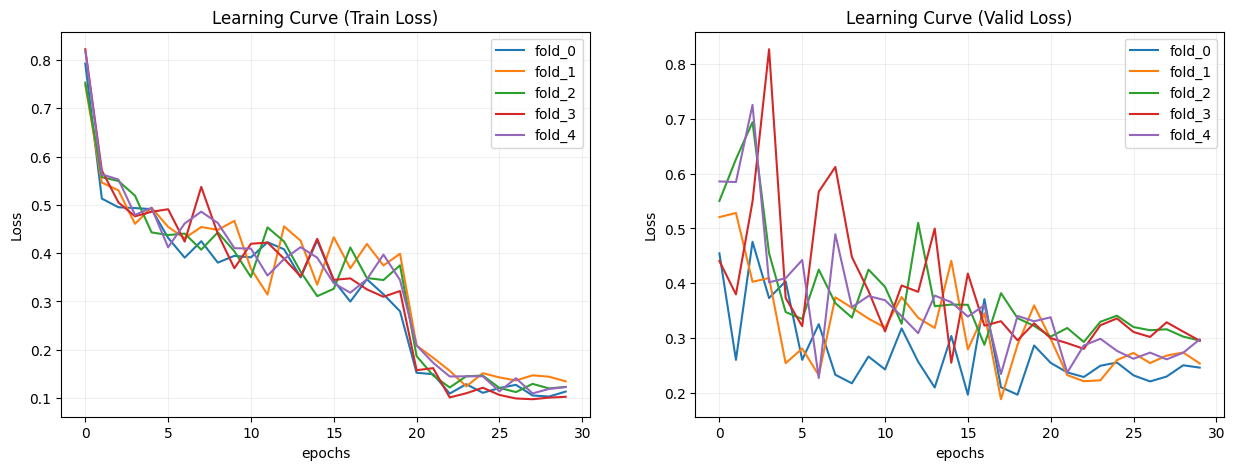

In [28]:
fig, axes = plt.subplots(1, 2, figsize=(15, 5))  # 1行2列のサブプロットを作成

for i, his in enumerate(list_history):
    axes[0].plot(his["Train Loss"], label=f"fold_{i}")  # 1つ目のサブプロットにTrain Lossを描画
    axes[1].plot(his["Valid Loss"], label=f"fold_{i}")  # 2つ目のサブプロットにValid Lossを描画

axes[0].set_title("Learning Curve (Train Loss)")
axes[0].set_ylabel("Loss")
axes[0].set_xlabel("epochs")
axes[0].legend()
axes[0].grid(alpha=0.2)
# axes[0].set_ylim([0, 1])

axes[1].set_title("Learning Curve (Valid Loss)")
axes[1].set_ylabel("Loss")
axes[1].set_xlabel("epochs")
axes[1].legend()
axes[1].grid(alpha=0.2)
# axes[1].set_ylim([0, 1])


# PillowのImageオブジェクトに変換
# img = Image.frombytes('RGB', fig.canvas.get_width_height(), fig.canvas.tostring_rgb())

# wandbに記録
# wandb.log({"learning_curve_loss": wandb.Image(img)})

plt.show()

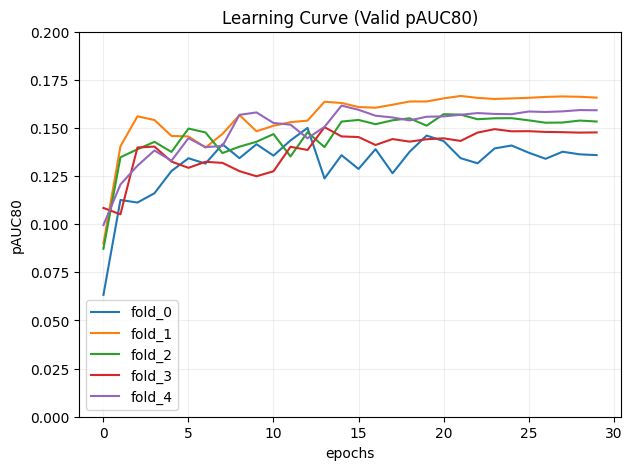

In [29]:
fig, ax = plt.subplots(figsize=(7, 5))  # 1列のサブプロットを作成

for i, his in enumerate(list_history):
    ax.plot(his["Valid AUROC"], label=f"fold_{i}")  # Valid AUROCのみを描画

ax.set_title("Learning Curve (Valid pAUC80)")
ax.set_ylabel("pAUC80")
ax.set_xlabel("epochs")
ax.legend()
ax.grid(alpha=0.2)
ax.set_ylim([0, 0.2])

# PillowのImageオブジェクトに変換
# img = Image.frombytes('RGB', fig.canvas.get_width_height(), fig.canvas.tostring_rgb())

# # wandbに記録
# wandb.log({"learning_curve_pAUC80": wandb.Image(img)})

plt.show()

In [30]:
if WANDB:
    data = [[x, y] for (x, y) in zip(range(len(his["Valid AUROC"].values)), his["Valid AUROC"].values)]
    table = wandb.Table(data=data, columns=["x", "y"])
    wandb.log(
        {
            "learning_curve_pAUC80": wandb.plot.line(
                table, "x", "y", title="Learning Curve (Valid pAUC80)"
            )
        }
    )

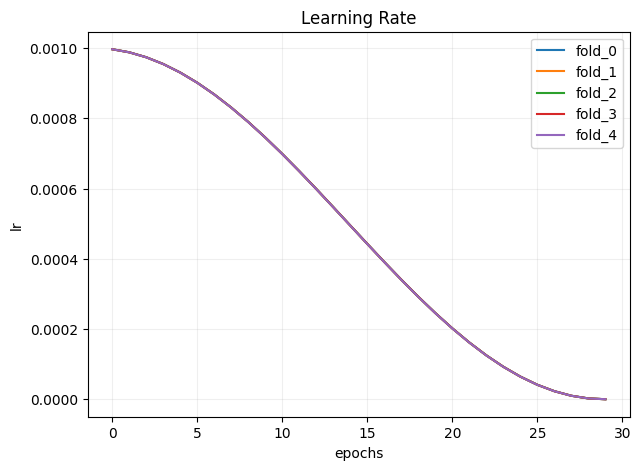

In [31]:
fig, ax = plt.subplots(figsize=(7, 5))
ax.grid(alpha=0.2)
for i, his in enumerate(list_history):
    ax.plot(his["lr"], label=f"fold_{i}")  # 1つ目のサブプロットにTrain Lossを描画

ax.set_title("Learning Rate")
ax.set_ylabel("lr")
ax.set_xlabel("epochs")
ax.legend()

plt.show()

In [32]:
pd.options.display.precision = 4

df_pauc = pd.DataFrame(columns=["pAUC80"])
for i, his in enumerate(list_history):
    df_pauc.loc[f"fold_{i}", "pAUC80"] = his["Valid AUROC"].values[-1]

df_pauc["pAUC80_notFiltered"] = list_score_notFiltered
df_pauc.loc["mean", "pAUC80"] = np.mean(df_pauc["pAUC80"])
df_pauc.loc["std", "pAUC80"] = np.std(df_pauc["pAUC80"])
df_pauc.loc["mean", "pAUC80_notFiltered"] = np.mean(df_pauc["pAUC80_notFiltered"])
df_pauc.loc["std", "pAUC80_notFiltered"] = np.std(df_pauc["pAUC80_notFiltered"])
df_pauc

,pAUC80,pAUC80_notFiltered
fold_0,0.1359,0.1348
fold_1,0.1658,0.1658
fold_2,0.1534,0.1534
fold_3,0.1477,0.1476
fold_4,0.1592,0.1569
mean,0.1524,0.1517
std,0.0093,0.0094


In [33]:
if WANDB:
    wandb.log({"pAUC80_fold0": df_pauc.loc["fold_0", "pAUC80"]})
    wandb.log({"pAUC80_fold1": df_pauc.loc["fold_1", "pAUC80"]})
    wandb.log({"pAUC80_fold2": df_pauc.loc["fold_2", "pAUC80"]})
    wandb.log({"pAUC80_fold3": df_pauc.loc["fold_3", "pAUC80"]})
    wandb.log({"pAUC80_fold4": df_pauc.loc["fold_4", "pAUC80"]})
    wandb.log({"pAUC80_mean": df_pauc.loc["mean", "pAUC80"]})

    wandb.log({"pAUC80_fold0_notFiltered": df_pauc.loc["fold_0", "pAUC80_notFiltered"]})
    wandb.log({"pAUC80_fold1_notFiltered": df_pauc.loc["fold_1", "pAUC80_notFiltered"]})
    wandb.log({"pAUC80_fold2_notFiltered": df_pauc.loc["fold_2", "pAUC80_notFiltered"]})
    wandb.log({"pAUC80_fold3_notFiltered": df_pauc.loc["fold_3", "pAUC80_notFiltered"]})
    wandb.log({"pAUC80_fold4_notFiltered": df_pauc.loc["fold_4", "pAUC80_notFiltered"]})
    wandb.log({"pAUC80_mean_notFiltered": df_pauc.loc["mean", "pAUC80_notFiltered"]})

    wandb.finish()

In [34]:
# wandb.finish()

In [37]:

for fold in range(5):
    score = df_pauc.loc[f"fold_{fold}", "pAUC80_notFiltered"]
    print("==="*10)
    print(f"Fold{fold} (Score: {score:.4f})")
    print("==="*10)
    tmp = list_df_pos_pred[fold].sort_values(by="pred", ascending=False).reset_index(drop=True)
    tmp["Rank"] = tmp.index
    tmp["Rank_percent"] = 100 * tmp["Rank"] / len(tmp) 
    pos = tmp.loc[tmp["target"]==1, ["isic_id", "patient_id", "Rank", "Rank_percent", "pred"]].reset_index(drop=True)
    display(pos.tail(10))
    print()

Fold0 (Score: 0.1348)


,isic_id,patient_id,Rank,Rank_percent,pred
63,ISIC_7745168,IP_2702014,17183,18.1871,0.0701
64,ISIC_9941636,IP_7607582,22248,23.5481,0.0372
65,ISIC_2235682,IP_2491677,23974,25.3750,0.0309
66,ISIC_1246526,IP_4717387,31364,33.1968,0.0165
67,ISIC_1621074,IP_6321403,32817,34.7347,0.0149
68,ISIC_3498683,IP_4177511,39648,41.9649,0.0096
69,ISIC_4843324,IP_4890448,50979,53.9580,0.0054
70,ISIC_9544804,IP_3206733,51326,54.3253,0.0053
71,ISIC_5221028,IP_3912094,52710,55.7902,0.0050
72,ISIC_3266736,IP_6321403,62515,66.1681,0.0032



Fold1 (Score: 0.1658)


,isic_id,patient_id,Rank,Rank_percent,pred
86,ISIC_7834218,IP_8241654,8672,10.0822,0.4888
87,ISIC_4495429,IP_6423094,9034,10.5031,0.4678
88,ISIC_8662001,IP_1999627,12657,14.7152,0.2867
89,ISIC_3964079,IP_1039004,12877,14.9710,0.2787
90,ISIC_0760004,IP_8275247,14610,16.9858,0.2209
91,ISIC_9420821,IP_5611762,19286,22.4222,0.1228
92,ISIC_0211092,IP_2203964,23088,26.8425,0.0809
93,ISIC_2604412,IP_6423094,30846,35.8620,0.0391
94,ISIC_2346081,IP_3140028,33492,38.9383,0.0313
95,ISIC_9207822,IP_4215006,56803,66.0400,0.0069



Fold2 (Score: 0.1534)


,isic_id,patient_id,Rank,Rank_percent,pred
48,ISIC_1623236,IP_0023586,10653,14.2048,0.3047
49,ISIC_6095295,IP_0325406,10915,14.5541,0.2908
50,ISIC_7074027,IP_2732171,12198,16.2649,0.2330
51,ISIC_1105843,IP_3026867,14525,19.3677,0.1556
52,ISIC_8731383,IP_1249536,14679,19.5730,0.1516
53,ISIC_1105887,IP_0277335,16621,22.1625,0.1126
54,ISIC_0275647,IP_7411721,17911,23.8826,0.0934
55,ISIC_4907011,IP_5709986,20915,27.8882,0.0632
56,ISIC_3581982,IP_5585622,34984,46.6478,0.0180
57,ISIC_5661573,IP_6723298,35710,47.6159,0.0171



Fold3 (Score: 0.1476)


,isic_id,patient_id,Rank,Rank_percent,pred
58,ISIC_6608075,IP_3823237,10098,13.3754,0.3204
59,ISIC_5328578,IP_4414342,10256,13.5846,0.3109
60,ISIC_5077618,IP_2331257,10707,14.1820,0.2824
61,ISIC_4023678,IP_4150126,12283,16.2695,0.2062
62,ISIC_7703236,IP_5294508,14268,18.8988,0.1398
63,ISIC_9762220,IP_1093030,18463,24.4553,0.0673
64,ISIC_2538516,IP_6141958,22474,29.7681,0.0377
65,ISIC_6424909,IP_0669361,44699,59.2063,0.0054
66,ISIC_7188117,IP_3619408,49501,65.5668,0.0041
67,ISIC_0287900,IP_8083700,52196,69.1365,0.0035



Fold4 (Score: 0.1569)


,isic_id,patient_id,Rank,Rank_percent,pred
88,ISIC_7499766,IP_3905195,10258,14.6388,0.3636
89,ISIC_5489626,IP_1741190,10276,14.6645,0.3624
90,ISIC_9521124,IP_6032376,12165,17.3602,0.2544
91,ISIC_5347922,IP_7848492,13247,18.9043,0.2109
92,ISIC_3167797,IP_5776495,14401,20.5511,0.1729
93,ISIC_3445540,IP_8557750,14729,21.0192,0.1634
94,ISIC_1705108,IP_4304202,16005,22.8401,0.1344
95,ISIC_4614975,IP_6032376,18082,25.8041,0.1003
96,ISIC_2581432,IP_9181133,51561,73.5808,0.0058
97,ISIC_8386743,IP_3905195,59722,85.2270,0.0035
